# Example Usage of SQLite-haystack in a Haystack Pipeline

**Author:** Alan Meeson <am@carefullycalculated.co.uk>

**Date:** 2024-03-29

This notebook provides an example of using the SQLite backed bm25 and embedding DocumentStore with Haystack 2.X.

## Setup

In [1]:
import os
from pathlib import Path
from datetime import datetime
from typing import Dict, Any

from haystack import Document, Pipeline
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.dataclasses import ByteStream
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

from sqlite_haystack import SQLiteDocumentStore, SQLiteEmbeddingRetriever, SQLiteBM25Retriever

## Declare the document store and associated settings

In [2]:
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
document_store = SQLiteDocumentStore(database=":memory:", use_bm25=True, embedding_dims=384)

## Do the Indexing

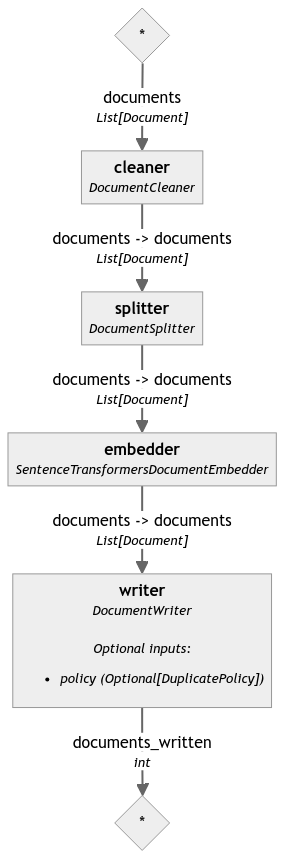

In [3]:
p = Pipeline()
p.add_component(instance=DocumentCleaner(), name="cleaner")
p.add_component(instance=DocumentSplitter(split_by="sentence", split_length=250, split_overlap=30), name="splitter")
p.add_component(
    instance=SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"), name="embedder"
)
p.add_component(instance=DocumentWriter(document_store=document_store), name="writer")
p.connect("cleaner.documents", "splitter.documents")
p.connect("splitter.documents", "embedder.documents")
p.connect("embedder.documents", "writer.documents")



In [4]:
docs = [
    Document(
        content="A man must appear somewhat vain, who declares that he has been obliged to reject much useful information, for fear of increasing too much the size of his work: and yet manages to find room for a few pages of his own, by way of Preface: but lest the objects which the compiler of this little work has had in view should be mistaken, he finds it absolutely necessary to say a few words in explanation of them. This small collection of military memorandums was originally intended only for the compiler’s own pocket; to assist him in the execution of his duty: but it occurred to him, that many of his military friends stood in equal need of such an aid, and would willingly give a few shillings for what they would not be at the trouble of collecting. The compiler has seen young men, on their first entry into the regiment of artillery, give a guinea for manuscripts, which contained a very small part of the information offered in this little book.",
        meta={
            'title': 'The Bombardier, and Pocket Gunner.',
            'author':'Ralph Willet Adye',
            'url':'https://gutenberg.org/cache/epub/73283/pg73283-images.html'
        }
    ),
    Document(
        content="26th July, 1799.—Left H. H. this morning to make a tour into Wales and the west of England. Ld. H. went to dine at St. Anne’s, and Drew, Charles, and myself came to this place (General Fitzpatrick’s, Sunninghill) to meet him. On Saturday, ye 27th, we arrived to dinner at Oxford. Close by the General’s, upon Ascot Heath, there is a camp. The cavalry were watered whilst we went on the road, a pretty incident; their brilliant coats contrasted with the dusky brown of the heath, and produced a very lively effect. A cross road to Henley; just as we entered the town we passed under Park Place, a late purchase of Ld. Malmesbury’s. Somewhere near Henley is the highest ground south of Trent. On ye 28th went from Oxford, by Chapel House, to Warwick. I could not help laughing at the event of our going, because the subject of seeing the Castle without being obliged by urgent solicitations to make a long visit there (as Ld. H. was sure we should be very much pressed) had occupied his thoughts for many hours. Ld. H. had written letters to Ly. W. and Mrs. Smith, so calculated as to make a refusal of the pressing invitations (which he dreaded having) quite civil; but we need not have been embarrassed. So far from being solicited to stay, the whole family flew to their fortresses in some battlemented towers, gave out[2] that they were walking, and shunned us. It was a most fortunate escape to me, tho’ I believe Ld. H. was vexed at the impertinence of the proceeding. The Castle is magnificent, decorated with ornaments appropriate to the building, and in the very best taste possible. His taste in virtu is better than in breeding, as he manifested a gross deficiency of that quality to us.",
        meta={
            'title': 'The journal of Elizabeth Lady Holland',
            'author':'Elizabeth Lady Holland',
            'url':'https://gutenberg.org/cache/epub/73280/pg73280-images.html'
        }
    )    
]

In [5]:
# Take the current directory as input and run the pipeline
result = p.run({"cleaner": {"documents": docs}})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
result

{'writer': {'documents_written': 2}}

## Query

### BM25

In [7]:
query_pipeline = Pipeline()
query_pipeline.add_component("bm25_retriever", SQLiteBM25Retriever(document_store=document_store))

In [8]:
query = "wales"
results = query_pipeline.run({"bm25_retriever": {"query": query}})
print(f"Number of Results: {len(results['bm25_retriever']['documents'])}")
results

Number of Results: 1


{'bm25_retriever': {'documents': [Document(id=5de0a36f2936e54b099798a464ebfa165fa07f19ff3bb24be84649175fed1050, content: '26th July, 1799.—Left H. H. this morning to make a tour into Wales and the west of England. Ld. H. w...', meta: {'title': 'The journal of Elizabeth Lady Holland', 'author': 'Elizabeth Lady Holland', 'url': 'https://gutenberg.org/cache/epub/73280/pg73280-images.html', 'source_id': '46837a04b17e813650375dcd676d218058427ba942fa41c4efb08afdba5605c4'}, score: -8.961303462321792e-07, embedding: vector of size 384)]}}

In [13]:
query = "vai"
results = query_pipeline.run({"bm25_retriever": {"query": query}})
print(f"Number of Results: {len(results['bm25_retriever']['documents'])}")
results

Number of Results: 1


{'bm25_retriever': {'documents': [Document(id=50bd7da4a4ccf12d4532be79fee2874d1d8846d1bbde305908ffb6718cf35aaa, content: 'A man must appear somewhat vain, who declares that he has been obliged to reject much useful informa...', meta: {'title': 'The Bombardier, and Pocket Gunner.', 'author': 'Ralph Willet Adye', 'url': 'https://gutenberg.org/cache/epub/73283/pg73283-images.html', 'source_id': '107e17318001c8f7f8c006d98e75318169924dff8c14af1bbe27a51868e4df5f'}, score: -1.1311053984575837e-06, embedding: vector of size 384)]}}

### Embedding

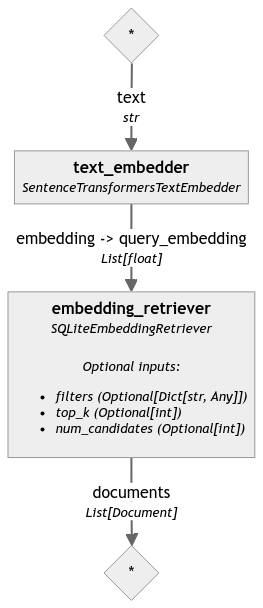

In [10]:
query_pipeline2 = Pipeline()
query_pipeline2.add_component("text_embedder", SentenceTransformersTextEmbedder(model=embedding_model))
query_pipeline2.add_component("embedding_retriever", SQLiteEmbeddingRetriever(document_store=document_store))
query_pipeline2.connect("text_embedder.embedding", "embedding_retriever")

In [11]:
query = "tour of the country"
results = query_pipeline2.run({"text_embedder": {"text": query}})
print(f"Number of Results: {len(results['embedding_retriever']['documents'])}")
results

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Number of Results: 2


{'embedding_retriever': {'documents': [Document(id=5de0a36f2936e54b099798a464ebfa165fa07f19ff3bb24be84649175fed1050, content: '26th July, 1799.—Left H. H. this morning to make a tour into Wales and the west of England. Ld. H. w...', meta: {'title': 'The journal of Elizabeth Lady Holland', 'author': 'Elizabeth Lady Holland', 'url': 'https://gutenberg.org/cache/epub/73280/pg73280-images.html', 'source_id': '46837a04b17e813650375dcd676d218058427ba942fa41c4efb08afdba5605c4'}, score: 1.3720530271530151, embedding: vector of size 384),
   Document(id=50bd7da4a4ccf12d4532be79fee2874d1d8846d1bbde305908ffb6718cf35aaa, content: 'A man must appear somewhat vain, who declares that he has been obliged to reject much useful informa...', meta: {'title': 'The Bombardier, and Pocket Gunner.', 'author': 'Ralph Willet Adye', 'url': 'https://gutenberg.org/cache/epub/73283/pg73283-images.html', 'source_id': '107e17318001c8f7f8c006d98e75318169924dff8c14af1bbe27a51868e4df5f'}, score: 1.9647462368011475, embe

In [12]:
query = "reject useful information"
results = query_pipeline2.run({"text_embedder": {"text": query}, "embedding_retriever": {"top_k": 1}})
print(f"Number of Results: {len(results['embedding_retriever']['documents'])}")
results

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Number of Results: 1


{'embedding_retriever': {'documents': [Document(id=50bd7da4a4ccf12d4532be79fee2874d1d8846d1bbde305908ffb6718cf35aaa, content: 'A man must appear somewhat vain, who declares that he has been obliged to reject much useful informa...', meta: {'title': 'The Bombardier, and Pocket Gunner.', 'author': 'Ralph Willet Adye', 'url': 'https://gutenberg.org/cache/epub/73283/pg73283-images.html', 'source_id': '107e17318001c8f7f8c006d98e75318169924dff8c14af1bbe27a51868e4df5f'}, score: 1.3857643604278564, embedding: vector of size 384)]}}